# Исследование поведения пользователей мобильного приложения

# Описание проекта

Нужно разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания.\
Изучим воронку продаж. После этого исследуем результаты A/A/B-эксперимента. В случае общей аналитики и A/A/B-эксперимента будем работать с одними и теми же данными.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Ход выполнения проекта

**Шаг 1. Откроем файл с данными и изучим общую информацию**

**Шаг 2. Подготовим данные**

**Задача:**
- Заменим названия столбцов на удобные для нас;
- Проверим пропуски и типы данных. Откорректируем их, если нужно;
- Добавим столбец даты и времени, а также отдельный столбец дат;

**Шаг 3. Изучим и проверим данные**

**Задача:**
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?
- Много ли событий и пользователей мы потеряли, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

**Шаг 4. Изучим воронку событий**

**Задача:**
- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.
- Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

**Шаг 5. Изучим результаты эксперимента**

**Задача:**
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

**Шаг 6. Вывод**

### Открыть файл с данными и изучить общую информацию

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt
from time import strptime
import math 
from plotly import graph_objects as go

In [2]:
# импортируем кроссплатформенную библиотеку для создания статических изображений 
! pip install -U kaleido

In [3]:
# загрузим данные 
logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [4]:
# выведем общую информацию
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# выведем первые 5 строк датафрейма
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В датафрейме 4 столбца и 244126 полей. Необходимо привести названия столбцов к змеиной нотации, а также изменить тип данных столбца со временем события `EventTimestamp`.

### Подготовка данных

In [6]:
# проверим наличие дубликатов
logs.duplicated().sum()

413

In [7]:
# найдем количество дубликатов в процентном соотношении
round(logs.duplicated().sum()/len(logs) * 100, 2)

0.17

В датафрейме было найдено 413 дубликатов - это 0.17% от общего числа записей. Удалим их.

In [8]:
# удалим дубликаты
logs = logs.drop_duplicates().reset_index(drop=True)

In [9]:
# проверим изменения
logs.duplicated().sum()

0

Дубликаты удалены.

In [10]:
# проверим наличие пропусков
logs.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Пропусков нет.

In [11]:
# переименуем столбцы
logs = logs.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp' : 'event_timestamp', 
                            'ExpId':'exp_id'})

In [12]:
# выведем названия столбцов и проверим изменения
logs.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [13]:
# приведем тип данных столбца logs['event_timestamp'] к типу данных datetime64
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')

In [14]:
# добавим столбец с датой
logs['event_date'] = pd.to_datetime(logs['event_timestamp'].dt.date)

In [15]:
# выведем ещё раз общую информацию
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [16]:
# посмотрим на первые строки
logs.head(5)

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


В результате предобработки данных заменили названия столбцов на названия в змеиной нотации, проверили пропуски и удалили 413 дубликатов (0.17% от общего числа записей), привели столбец `event_timestamp` к типу данных datetime64[ns] в результате чего получили столбец с нужным форматом даты и временем события, а также отдельно добавили столбец с датой.

### Изучение и проверка данных

- Сколько всего событий в логе?

In [17]:
# уникальных событий в логе
print('Уникальных событий в логе: \n', logs['event_name'].nunique())

# количество каждого события
print('Количество каждого события: \n', logs['event_name'].value_counts())

# суммарное количество событий в логе
print('Суммарное количество событий в логе :\n', logs.shape[0])

Уникальных событий в логе: 
 5
Количество каждого события: 
 MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64
Суммарное количество событий в логе :
 243713


Всего уникальных событий в логе 5. В сумме этих событий 243713. Больше всего MainScreenAppear - 119101, меньше всего - Tutorial - 1018.

- Сколько всего пользователей в логе?

In [18]:
# уникальных  пользователей в логе
print('Уникальных пользователей в логе: \n', logs['device_id_hash'].nunique())

Уникальных пользователей в логе: 
 7551


Всего 7551 пользователей.

- Сколько в среднем событий приходится на пользователя?

In [19]:
# количество событий на пользователя
print('Событий на 1 пользователя:', round(logs['event_name'].count() / logs['device_id_hash'].nunique(),1))

Событий на 1 пользователя: 32.3


В среднем на 1 пользователя приходится 32 события.

- Данными за какой период вы располагаете? 

In [20]:
# максимальная и минимальная даты
print('Максимальная дата:', logs['event_timestamp'].max())
print('Минимальная дата:', logs['event_timestamp'].min())

Максимальная дата: 2019-08-07 21:15:17
Минимальная дата: 2019-07-25 04:43:36


Максимальная дата - 7 августа 2019 года, минимальная дата - 25 июля 2019 года.

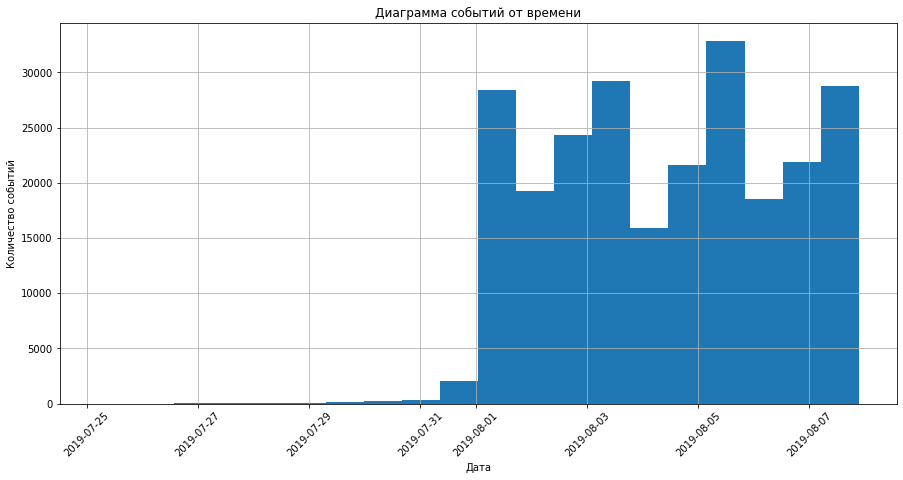

In [21]:
plt.figure(figsize=(15,7))
logs['event_timestamp'].hist(bins=20)
plt.title('Диаграмма событий от времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

Исходя из графика видно, что данные до 2019-08-01 практически отсутствуют. Одинаково полные данные обеспечиваются только с 1 августа. Отбросим данные до 1 августа.

In [22]:
# сделаем срез с 1 августа и отбросим "старые" данные
logs_new = logs.query('event_date > "2019-07-31"')

In [23]:
# проверим изменения максимальной и минимальной даты
print('Максимальная дата:', logs_new['event_timestamp'].max())
print('Минимальная дата:', logs_new['event_timestamp'].min())

Максимальная дата: 2019-08-07 21:15:17
Минимальная дата: 2019-08-01 00:07:28


Теперь данные представлены с 1 по 7 августа.

- Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [24]:
# количество событий после чистки 
print('Количество событий после чистки:', logs_new.shape[0])
print('Количество потерянных событий:', logs.shape[0]- logs_new.shape[0])
print('% потерянных событий:', round((logs.shape[0]- logs_new.shape[0])/logs.shape[0] * 100, 2))

Количество событий после чистки: 240887
Количество потерянных событий: 2826
% потерянных событий: 1.16


In [25]:
#количество уникальных пользователей после чистки 
print('Количество пользователей после чистки:', logs_new['device_id_hash'].nunique())
print('Количество потерянных пользователей:', logs['device_id_hash'].nunique()- logs_new['device_id_hash'].nunique())
print('% потерянных пользователей:', round((logs['device_id_hash'].nunique()- logs_new['device_id_hash'].nunique())/logs['device_id_hash'].nunique()*100, 2))


Количество пользователей после чистки: 7534
Количество потерянных пользователей: 17
% потерянных пользователей: 0.23


Отбросив старые данные мы потеряли 1.16% записей (2826 записей) и 0.23% пользователей (17 пользователей). Небольшой процент.

- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

In [26]:
# количество пользователей по группам
logs_new.groupby('exp_id')['device_id_hash'].nunique().sort_values(ascending = False)

exp_id
248    2537
247    2513
246    2484
Name: device_id_hash, dtype: int64

В данных представлены пользователи из всех трёх экспериментальных данных - 248, 246 и 247.\
Чуть больше, чем в остальных их в 248 группе - 2537 пользователей, далее в 247 - 2513 пользователей и в 246 - 2484 пользователей.\
Проверим корректность разбиения пользователей на группы - нет ли пользователей, попавших в несколько групп.\
Для этого используем функцию np.intersect1d(): 
- функция intersect1d() возвратит пересечение двух массивов, т.е. уникальные элементы, которые встречаются в обоих.

In [27]:
# пресечение групп 246 и 247
len(np.intersect1d(logs_new.query('exp_id == 246')['device_id_hash'].unique(), logs_new.query('exp_id == "247"')['device_id_hash'].unique()))

0

In [28]:
# пресечение групп 246 и 248
len(np.intersect1d(logs_new.query('exp_id == 246')['device_id_hash'].unique(), logs_new.query('exp_id == "248"')['device_id_hash'].unique()))

0

In [29]:
# пресечение групп 247 и 248
len(np.intersect1d(logs_new.query('exp_id == 247')['device_id_hash'].unique(), logs_new.query('exp_id == "248"')['device_id_hash'].unique()))

0

Пересечений групп не найдено.

### Изучение воронки событий

- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [30]:
# уникальных событий в логе
print('Уникальных событий в логе: \n', logs['event_name'].nunique())

# количество каждого события
print('Количество каждого события: \n', logs['event_name'].value_counts())

Уникальных событий в логе: 
 5
Количество каждого события: 
 MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


Всего событий в логе 5 - это :
1. MainScreenAppear - появление главного экрана (119101)
2. OffersScreenAppear - появление экрана предложений (46808)
3. CartScreenAppear - появление экрана корзины (42668)
4. PaymentScreenSuccessful - экран успешной оплаты (34118)
5. Tutorial – учебное пособие (1018)

Частота появления указана в скобках. Чаще всего появляется главный экран, затем предложение, далее корзина и успешная оплата, логично. Реже всего пользователи пользуются обучающими материалами.

- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

Для расчёта количества/доли пользователей совершавших каждое из событий напишем функцию для определения воронки.

In [31]:
# напишем функцию для определения воронки
def funnel_users(logs_funnel):
    #сгруппируем данные по событию, его частоте и количеству уникальных пользователей
    funnel = (
        logs_funnel.groupby('event_name')
              .agg({'event_name':'count', 'device_id_hash': 'nunique'})
              .rename(columns={'event_name':'event_cnt', 'device_id_hash':'users_cnt'})
              .sort_values(by ='event_cnt', ascending=False).reset_index())
    #конверсия, доля пользователей которая хоть раз совершала событие
    funnel['cr, %'] = round((funnel['users_cnt'] / logs_funnel['device_id_hash'].nunique()) * 100, 1)    
    # сдвиг столбца users_cnt на одну строку вниз
    funnel['step'] = funnel['users_cnt'].shift() 
    # конверсия в следующий шаг
    funnel['cr_step, %'] = round(funnel['users_cnt'] / funnel['step'] * 100, 1)
    #удаляем столбец step
    funnel.drop(columns= ['step'], axis = 1, inplace = True)
    return funnel


In [32]:
# Зададим воронку
funnel = funnel_users(logs_new)

# выведем на экран
funnel

,event_name,event_cnt,users_cnt,"cr, %","cr_step, %"
0,MainScreenAppear,117328,7419,98.5,NaN
1,OffersScreenAppear,46333,4593,61.0,61.9
2,CartScreenAppear,42303,3734,49.6,81.3
3,PaymentScreenSuccessful,33918,3539,47.0,94.8
4,Tutorial,1005,840,11.1,23.7


По столбцу `users_cnt` видно какое количество пользователей совершало то или иное событие. Частота выполнения события тем выше, чем чаще в целом совершалось событие.\
Так чаще всего пользователи (7419 пользователей) переходили на главный экран ( и только 1.5 % не дошли до него). Далее пользователи переходили на экран с предложением (61% пользователей от общего числа - 4593 пользователей), половина от общего числа добавила что-то в корзину (3734 пользователей) и 47% пользователей (3539) оплатили покупку.\
Обучающий материал просматривают лишь 11 % пользователей(840).

- Предположите, в каком порядке происходят события

Пользователи скачивают приложение, им сразу открывается главный экран, а перед этим возможность пройти обучение(лишь 11% из них проходят его) остальные его пропускают и переходят от главного экрана к поиску товара, переходят на страницу предложений, добавляют товар в корзину и затем оплачивают его.

- По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

Визуализируем воронку:

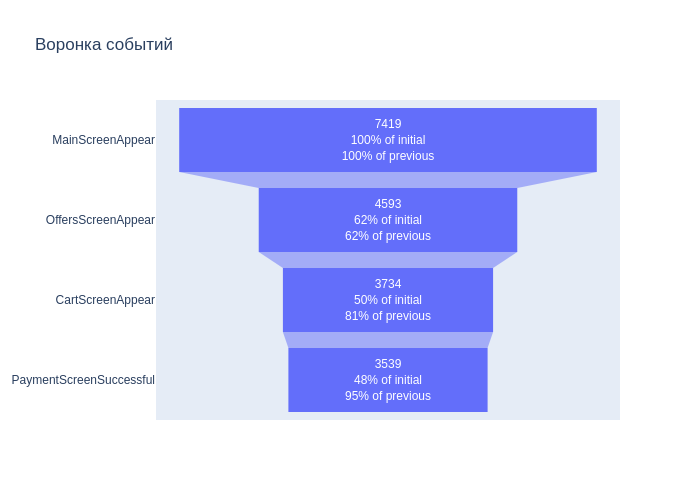

In [33]:
# визуализируем воронку событий
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel.loc[:3,'users_cnt'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка событий')
fig.show(renderer='png')

Первый шаг воронки - MainScreenAppear - появление главного экрана, примем за 100%. Далее по воронке событий видно, что 62% из этих пользователей переходят на экран предложений, затем 81% из них и 50% пользователей от первоночального количества добавляют товар в корзину и 95% из добавивших(48% от первого шага) успешно оплачивают покупку.

- На каком шаге теряете больше всего пользователей?

Больше всего пользователей (38%) отваливаются на пути между главным экраном и переходом к предложениям. Возможно пользователи сталкиваются с какими-то трудностями использования, функциональности, доступности при переходе от главного экрана к предложениям.

- Какая доля пользователей доходит от первого события до оплаты?

От первого шага (главного экрана) до последнего (успешной оплаты) доходят 48% пользователей.

### Изучение результатов эксперимента

- Сколько пользователей в каждой группе?

In [34]:
# найдем количество пользователей в каждой группе 
group_users = logs_new.groupby('exp_id')['device_id_hash'].nunique().sort_values(ascending = False)

# выведем на экран
group_users

exp_id
248    2537
247    2513
246    2484
Name: device_id_hash, dtype: int64

Больше всего пользователей - 2537 в группе 248, в 247 группе - 2513 пользователей и в 246 группе 2484 пользователей.\
Посмотрим насколько отличаются группы между собой.

In [35]:
# посчитаем доли каждых групп между собой
print('Разница в процентах между размерами групп:', '\n',
     '246 от 247:', round((group_users[246]- group_users[247])/group_users[246] * 100, 1), '\n',
     '246 от 248:', round((group_users[246]- group_users[248])/group_users[246] * 100, 1), '\n',
     '247 от 248:', round((group_users[247]- group_users[248])/group_users[247] * 100, 1), '\n',
    )

Разница в процентах между размерами групп: 
 246 от 247: -1.2 
 246 от 248: -2.1 
 247 от 248: -1.0 



Размеры выборок отличаются друг от друга : 246 от 247 на 1.2% , 246 от 248 на 2.1%, а 247 от 248 на 1%.

- Посчитаем число и долю пользователей, совершивших каждое событие в каждой из групп

In [36]:
# сделаем сводную таблицу для с разбивкой по пользователям совершивших каждое событие
funnel_group = (
    logs_new.query('event_name != "Tutorial"')
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246, ascending = False))

# добавим столбец с объединенными данными 246 и 247 группой и назовем его 249
funnel_group[249] =  funnel_group[246] + funnel_group[247]

# выведем на экран
funnel_group

exp_id,246,247,248,249
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [37]:
# посмотрим детальнее на 246 группу
funnel_users(logs_new.query('exp_id == 246 and event_name != "Tutorial"'))

,event_name,event_cnt,users_cnt,"cr, %","cr_step, %"
0,MainScreenAppear,37676,2450,98.7,NaN
1,OffersScreenAppear,14767,1542,62.1,62.9
2,CartScreenAppear,14690,1266,51.0,82.1
3,PaymentScreenSuccessful,11852,1200,48.3,94.8


In [38]:
# посмотрим детальнее на 247 группу
funnel_users(logs_new.query('exp_id == 247 and event_name != "Tutorial"'))

,event_name,event_cnt,users_cnt,"cr, %","cr_step, %"
0,MainScreenAppear,39090,2476,98.6,NaN
1,OffersScreenAppear,15179,1520,60.5,61.4
2,CartScreenAppear,12434,1238,49.3,81.4
3,PaymentScreenSuccessful,9981,1158,46.1,93.5


Приблизительно равные цифры демонстрируют контрольные группы. Проверим есть ли статистически значимые различия между ними.

Критерии успешного A/A/В-теста:
- Количество пользователей в различных группах различается не более, чем на 1%
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Напишем функцию для проведения z-теста для проверки гипотезы о равенстве долей двух выборок.

In [39]:
def z_test(exp_group_1, exp_group_2, event, alpha):
   
    # критический уровень статистической значимости
    bonf_alpha = alpha/16
    
    group_1 = logs_new.query('exp_id == @exp_group_1')
    group_2 = logs_new.query('exp_id == @exp_group_2')

    # значения выборок на уровне тестируемого события
    successes = np.array([funnel_group.query('event_name == @event')[exp_group_1].sum(),
                          funnel_group.query('event_name == @event')[exp_group_2].sum()])
    
    # первоначальные значения выборок
    trials = np.array([group_1['device_id_hash'].nunique(), group_2['device_id_hash'].nunique()])
    
    # пропорция успехов в группах:
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp_group_1, exp_group_2, event, p_value=p_value))
    if  p_value < bonf_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Гипотезы сформулируем так:
- Нулевая гипотеза Н0 : доли двух выборок одинаковые
- Альтернативная гипотеза Н1 : доли двух выборок разные

Выберем уровень статистической значимости равный 0.05.

In [40]:
# напишем чикл для расчета функции по каждому событию
for event in funnel_group.index:
    z_test(246, 247, event, 0.05)
    print()

Проверка для групп 246 и 247, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Исходя из A/A тестов не получилось отвергнуть нулевую гипотезу, статистической значимости между выборками 246 и 247 нет. Можно сказать, что разбиение на группы работает корректно.

- Аналогично поступите с группой с изменённым шрифтом.\
Сравним контрольные группы с экспериментальной.

In [41]:
# посмотрим детальнее на 248 группу
funnel_users(logs_new.query('exp_id == 248 and event_name != "Tutorial"'))

,event_name,event_cnt,users_cnt,"cr, %","cr_step, %"
0,MainScreenAppear,40562,2493,98.3,NaN
1,OffersScreenAppear,16387,1531,60.4,61.4
2,CartScreenAppear,15179,1230,48.5,80.3
3,PaymentScreenSuccessful,12085,1181,46.6,96.0


Гипотезы будут звучать так же:

Нулевая гипотеза Н0 : доли двух выборок одинаковые\
Альтернативная гипотеза Н1 : доли двух выборок разные

In [42]:
# напишем чикл для расчета функции по каждому событию групп 246 и 248
for event in funnel_group.index:
    z_test(246, 248, event, 0.05)
    print()

Проверка для групп 246 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 246 и 248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Не получилось отвергнуть нулевую гипотезу, статистической значимости между выборками 246 и 248 ни по одному из событий нет.

In [43]:
# напишем чикл для расчета функции по каждому событию групп 247 и 248
for event in funnel_group.index:
    z_test(247, 248, event, 0.05)
    print()

Проверка для групп 247 и 248, событие: MainScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 247 и 248, событие: OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 247 и 248, событие: CartScreenAppear, p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Не получилось отвергнуть нулевую гипотезу, статистической значимости между выборками 247 и 248 ни по одному из событий нет.

Перепишем функцию для подсчёта статистической значимости для сравнения с объединенной группой

In [44]:
def z_test_2(exp_group_2, event, alpha):
   
    # критический уровень статистической значимости
    bonf_alpha = alpha/16
    
    group_1 = logs_new.query('exp_id == 246 | exp_id == 247')
    group_2 = logs_new.query('exp_id == @exp_group_2')

    # значения выборок на уровне тестируемого события
    successes = np.array([funnel_group.query('event_name == @event')[249].sum(),
                          funnel_group.query('event_name == @event')[exp_group_2].sum()])
    
    # первоначальные значения выборок
    trials = np.array([group_1['device_id_hash'].nunique(), group_2['device_id_hash'].nunique()])
    
    # пропорция успехов в группах:
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(249, exp_group_2, event, p_value=p_value))
    if  p_value < bonf_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [45]:
# напишем чикл для расчета функции по каждому событию группы 248 с объединенной группой (246+247)
for event in funnel_group.index:
    z_test_2(248, event, 0.05)
    print()

Проверка для групп 249 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 249 и 248, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 249 и 248, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для групп 249 и 248, событие: PaymentScreenSuccessful, p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Не получилось отвергнуть нулевую гипотезу, статистической значимости между выборками 248 и объединенной контрольной группой ни по одному из событий нет.

При проверке статистических гипотез выше был выбран уровень статистической значимости 0.05, но так как были проведены множественные сравнения ( в сумме проверено 16 гипотез) применим поправку Бонферрони, чтобы исключить возможность получить ложнопозитивный результат. 

После изменения уровня статистической значимости с учётом поправки Бонферрони результаты не изменились - не удалось отвергнуть ни одну из 16 гипотез. Нет основания считать доли разными.\
По результатам A/A/B-теста можно сказать, что нововведение никак не повлияло на пользователей.

### Вывод

В результате анализа пользования мобильным приложения по доставке продуктов питания 3-х групп пользователей (2 группы контрольные - использующие предыдущию версию приложения и 1 экспериментальная - с новыми шрифтами) с 1 по 7 августа 2019 года было определено:

**Всего уникальных событий** в логе 5 - это :
1. MainScreenAppear - появление главного экрана (119101)
2. OffersScreenAppear - появление экрана предложений (46808)
3. CartScreenAppear - появление экрана корзины (42668)
4. PaymentScreenSuccessful - экран успешной оплаты (34118)
5. Tutorial – учебное пособие (1018)\
(Частота событий указана в скобках)

- Всего было проанализировано "поведение" 7551 пользователя
- В среднем на каждого пользователя приходится 32 события

**Воронка продаж** формируется так: 
1. Появление главного экрана
2. Переход на экран предложений
3. Добавление товара в корзину
4. Оплата

- Чаще всего пользователи (7419 пользователей) переходили на главный экран ( и только 1.5 % не дошли до него) 
- Далее пользователи переходили на экран с предложением (62% - 4593 пользователей)
- Половина от общего числа добавила что-то в корзину (3734 пользователей) 
- И 48% пользователей (3539) оплатили покупку
- Обучающий материал просмотрели лишь 11 % пользователей(840)


- Самый большой процент оттока пользователей (38%) происходит на этапе главный экран - экран предложений

**Результаты А/А/В-теста:**

- В общей сложности было проведено 16 проверок гипотез
- 4 проверки двух контрольных групп между собой
- 12 проверок в общей сложности экспериментальной группы (с новыми шрифтами) с контрольными. По 4 проверки с каждой из контрольной группы и 4 проверки с объединенными данными из 2 контрольных групп вместе взятых
- В каждой группе было около 2500 пользователей
- **При статистической проверки гипотез не было найдено ни одного статистически значимого различия между группами** (все нулевые гипотезы отвергнуты), т.е выборки каждой из групп не имеют значимых различий друг относительно друга

По результатам теста можно сделать **вывод**, что введение новых шрифтов никак не повлияло на пользователей (ни в положительную, ни в отрицательную стороны).

**Рекомендации:**
Больше всего пользователей (38%) отваливаются на пути между главным экраном и переходом к предложениям. Возможно пользователи сталкиваются с какими-то трудностями использования, функциональности, доступности при переходе от главного экрана к предложениям. Нужно это проверить 
